# Clase 6: detección de objetos

**Profesor de Cátedra:** José M. Saavedra.

**Profesor Auxiliar:** Cristóbal Loyola (cloyola@dcc.uchile.cl)

En la clase práctica de hoy, resolveremos un problema de detección de objetos con dos modelos distintos: YoloV5 y RetinaNet. Específicamente, estaremos interesados en detectar dígitos manuscritos (10 clases distintas) en imágenes de cheques. Los datos se pueden descargar desde el siguiente link: https://www.dropbox.com/s/yf6uhsez5f2rau0/orand-car-with-bbs.zip?dl=0 (la contraseña es *cc7221*). Como el link necesita una contraseña, los datos se descargarán desde Google Drive y no directamente usando wget.

Para montar el contenido de Google Drive en la sesión de Colab, pinchamos el botón de "Activar unidad de Drive" en el menú de la izquierda. Luego podemos usar el comando *cp* para copiar los datos desde Drive a Colab.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Copiamos los datos al entorno de Colab
!mkdir /content/data
%cd /content/data
!cp /content/drive/MyDrive/t2-data/orand-car-with-bbs.zip .
!unzip -q orand-car-with-bbs.zip
!rm orand-car-with-bbs.zip

/content/data
cp: cannot stat '/content/drive/MyDrive/t2-data/orand-car-with-bbs.zip': No such file or directory
unzip:  cannot find or open orand-car-with-bbs.zip, orand-car-with-bbs.zip.zip or orand-car-with-bbs.zip.ZIP.
rm: cannot remove 'orand-car-with-bbs.zip': No such file or directory


## YOLOv5

La implementación de este modelo se puede encontrar en el siguiente repositorio: https://github.com/ultralytics/yolov5 (para más información, ir [aquí](https://towardsai.net/p/computer-vision/yolo-v5%E2%80%8A-%E2%80%8Aexplained-and-demystified)). Para llevar a cabo el entrenamiento sobre un dataset personalizado, pueden seguir este tutorial: https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data. Los pasos más relevantes son crear un archivo de configuración que contenga la ruta de las imágenes, la cantidad de clases y los nombres de las categorías. Además, debemos convertir las coordenadas de las anotaciones desde el formato [class_idx, xmin, ymin, width, height] que viene con el dataset a un formato [class_idx, x_center, y_center, width, height], donde las coordenadas están normalizadas por el tamaño de la imagen. El resto del proceso se puede llevar a cabo tal como se indica en el tutorial y en el README del repositorio. Para modificar los parámetros de detección, pueden revisar los argumentos del archivo *detect.py* (incluye la opción de NMS).

### Convertir coordenadas

El primer paso será convertir el formato de las anotaciones como se mencionó anteriormente. El código requiere tener las imágenes en un directorio llamado 'images' y las anotaciones en un directorio llamado 'labels'.


In [4]:
%cd /content/data/orand-car-with-bbs/training
!mkdir labels

import cv2
import glob
import os

filenames = glob.glob("./annotations/*.txt")

# Iteramos sobre todas las imágenes
for filename in filenames:

    # Abrimos la imagen para obtener sus dimensiones
    img_path = filename.split("/")[-1].replace(".txt", ".png")
    img_path = os.path.join("./images", img_path)
    img = cv2.imread(img_path)
    img_height, img_width, _ = img.shape

    # Obtenemos las coordenadas de cada objeto en la imagen
    with open(filename, 'r') as f:
        lines = f.readlines()
        lines = [x.strip() for x in lines]
        lines = [x.replace(' ', '') for x in lines]

    annotations_yolo = []
    # Iteramos sobre todas las anotaciones de la imagen
    for obj in lines:
        label = obj.split(":")[0]
        bbox = obj.split(":")[1]
        bbox = bbox.replace(",", " ")

        annotation = label + " " + bbox
        ann = annotation.split(" ")
        ann = [int(x) for x in ann]
        label = ann[0]
        xmin, ymin, width, height = ann[1:]

        # Obtenemos las coordenadas normalizadas
        x_center = (xmin + (width / 2)) / img_width
        y_center = (ymin + (height/ 2)) / img_height
        width = width / img_width
        height = height / img_height

        obj_info = [label, x_center, y_center, width, height]
        annotations_yolo.append(obj_info)

    # Escribimos las nuevas anotaciones en un archivo del mismo nombre pero 
    # en el directorio labels
    new_filename = filename.split("/")[-1]
    new_filename = os.path.join("./labels", new_filename)
    with open(new_filename, mode='w') as outfile:
        for annotation in annotations_yolo:
            annotation = [str(x) for x in annotation]
            line = ' '.join(annotation)
            outfile.write("%s\n" % line)

[Errno 2] No such file or directory: '/content/data/orand-car-with-bbs/training'
/content/data


In [5]:
# Ejemplo de anotación antigua
!cat /content/data/orand-car-with-bbs/training/annotations/0001_5179655_46066.txt

cat: /content/data/orand-car-with-bbs/training/annotations/0001_5179655_46066.txt: No such file or directory


In [6]:
# Ejemplo de la misma anotación pero con el nuevo formato
!cat /content/data/orand-car-with-bbs/training/labels/0001_5179655_46066.txt

cat: /content/data/orand-car-with-bbs/training/labels/0001_5179655_46066.txt: No such file or directory


Ahora dividiremos los datos en un conjunto de entrenamiento y uno de test, en una proporción 90%-10% respectivamente.

In [7]:
%cd /content/data/orand-car-with-bbs/training

import numpy as np
import random

filenames = glob.glob("images/*.png")
random.shuffle(filenames)

n = len(filenames)
split_ratio = 0.9
split_index = np.rint(n * split_ratio).astype("int")

train_split = filenames[:split_index]
test_split = filenames[split_index:]

train_dir = "/content/data/orand-car-with-bbs/training/"

with open("train.txt", mode='w') as outfile:
    for annotation in train_split:
        annotation = os.path.join(train_dir, annotation)
        outfile.write("%s\n" % annotation)

with open("test.txt", mode='w') as outfile:
    for annotation in test_split:
        annotation = os.path.join(train_dir, annotation)
        outfile.write("%s\n" % annotation)

print(f"Total de imágenes: {n}")
print(f"Imágenes de entrenamiento: {len(train_split)}")
print(f"Imágenes de test: {len(test_split)}")

[Errno 2] No such file or directory: '/content/data/orand-car-with-bbs/training'
/content/data
Total de imágenes: 0
Imágenes de entrenamiento: 0
Imágenes de test: 0


### Entrenamiento

Para el entrenamiento seguiremos los siguientes pasos:

* Clonar el repositorio de YOLOv5.
* Instalar las librerías requeridas.
* Modificar los archivos de configuración necesarios.

In [8]:
# Clonamos el repositorio
%cd /content
!git clone https://github.com/ultralytics/yolov5

# Instalamos los requisitos
%cd /content/yolov5
!pip install -r requirements.txt

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 10008, done.
remote: Total 10008 (delta 0), reused 0 (delta 0), pack-reused 10008
Receiving objects: 100% (10008/10008), 10.35 MiB | 31.00 MiB/s, done.
Resolving deltas: 100% (6938/6938), done.
/content/yolov5
     |████████████████████████████████| 596 kB 5.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Ahora agregaremos el siguiente archivo de configuración en el directorio ```/content/yolov5/data```, con el nombre *digits.yaml*:



```
train: /content/data/orand-car-with-bbs/training/train.txt
val: /content/data/orand-car-with-bbs/training/test.txt

# number of classes
nc: 10

# class names
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
```



In [9]:
# Entrenamos el modelo
# %cd /content/yolov5
# !python train.py --img 640 --batch 16 --epochs 10 --data digits.yaml --weights yolov5s.pt

In [10]:
# Guarda resultados en drive
# !cp -r /content/yolov5/runs/train /content/drive/MyDrive/t2-train

In [11]:
# Restaura resultados en yolo
!mkdir /content/yolov5/runs/
!cp -r /content/drive/MyDrive/t2-train/train /content/yolov5/runs/

cp: cannot stat '/content/drive/MyDrive/t2-train/train': No such file or directory


### Testing

In [12]:
# %cd /content/yolov5
# !python detect.py --source /content/data/orand-car-with-bbs/test/images --weights runs/train/exp/weights/best.pt --conf 0.25 --save-txt

In [13]:
# !cp -r /content/yolov5/runs/detect /content/drive/MyDrive/t2-detect

In [14]:
# Restaurar datos detectados
!cp -r  /content/drive/MyDrive/t2-detect/detect/ /content/yolov5/runs/

cp: cannot stat '/content/drive/MyDrive/t2-detect/detect/': No such file or directory


In [15]:
from IPython.display import Image, display

display(Image('/content/yolov5/runs/train/exp/confusion_matrix.png'))
display(Image('/content/yolov5/runs/train/exp/results.png'))
display(Image('/content/yolov5/runs/train/exp/val_batch2_labels.jpg'))
display(Image('/content/yolov5/runs/train/exp/val_batch2_pred.jpg'))

# Cálculo de accurracy conjunto de test

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

## Pruebas

TypeError: ignored

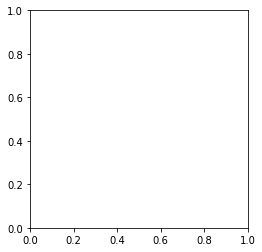

In [17]:
img = cv2.imread("/content/yolov5/runs/detect/exp/handwritten_MX8900201925093637024_maEnO1gFYEWnCyVkm4IPuQ.bmp")
plt.imshow(img)

In [ ]:
!cat /content/yolov5/runs/detect/exp/labels/handwritten_MX8900201925093637024_maEnO1gFYEWnCyVkm4IPuQ.txt


In [ ]:
#ordenando los objetos encontrados de izquierda a derecha (por ejemplo, 
#en base a la coordenada x de la esquina superior izquierda del bounding box, o a la coordenada x del centro).
data = pd.read_csv('/content/yolov5/runs/detect/exp/labels/handwritten_MX8900201925093637024_maEnO1gFYEWnCyVkm4IPuQ.txt', header = None, sep=" ")
data = data.sort_values(by=1)
values = data[0].values.tolist()
int(''.join(str(val) for val in values))

## Cálculo total

In [ ]:
!cp /content/data/orand-car-with-bbs/test/list.txt /content/yolov5/runs/list.txt

In [ ]:
class Metrics:
  def __init__(self):
    self.positives = []
    self.negatives = []
    self.accuraccy = 0

  def calculate_accuracy(self):

      # Definición de los archivos de detección a recorrer
      data_dir = "/content/yolov5/runs/detect/exp/labels/"
      labels_files = glob.glob(data_dir + "*.txt")

      # Las etiquetas reales se llevan a DataFrame
      real = pd.read_csv('/content/yolov5/runs/list.txt', header = None, sep="\t")

      # Contadores para cálculo de métricas
      n_positive = 0
      n_negative = 0
      n_total = len(labels_files)

      # Iteramos sobre los archivos de detección
      for idx, label_file in enumerate(labels_files):

        # Se obtiene el nombre del archivo txt y su imagen correspondiente
        name_file = label_file.split('/')[7]
        img_file = name_file.replace('.txt', '.bmp')

        # Se obtiene el valor detectado en el archivo utilizando DataFrame
        # ordenando los dígitos encontrados en base a la coordenada x
        data = pd.read_csv(data_dir+name_file, header = None, sep=" ")
        data = data.sort_values(by=1)

        # Se concatenan los dígitos para obtener el valor final
        values = data[0].values.tolist()
        amount = int(''.join(str(val) for val in values))

        # Se obtiene el valor real del archivo
        real_amount = (real.loc[real[0] == img_file])[1].values[0]

        record = {
            'file': img_file,
            'real': real_amount,
            'detected': amount,
        }
        
        # Se compara el monto detectado con el monto real
        if (amount == real_amount ):
          self.positives.append(record)
          n_positive += 1
        else:
          self.negatives.append(record)
          n_negative += 1

        # Se imprime información
        log = """
          ---- Calculating File {} ----
          detected amount: {}
          real amount:     {}
          positive:        {}
          -----------------------------
          """.format(
              name_file,
              amount,
              real_amount,
              amount == real_amount
          )
        print(log)

      # Se calcula el accuraccy
      self.accuraccy = n_positive / n_total

      # Muestra resultados
      result = {
          'n_positive: ': n_positive,
          'n_negative: ': n_negative,
          'n_total: ': n_total,
          'accuracy': self.accuraccy
      }
      print(result)

  def show_negative_results(self):
    data_test_dir = "/content/data/orand-car-with-bbs/test/images/"
    fig = plt.figure(figsize=(20, 40))
    rows = 15
    columns = 5
    position = 1

    for img in self.negatives:
      image = cv2.imread(data_test_dir+img['file'])
      title = "real: {} \n detected: {}".format(img['real'], img['detected'])
      fig.add_subplot(rows, columns, position)
      plt.imshow(image)
      plt.axis('off')
      plt.title(title)
      position += 1


In [ ]:
m = Metrics()
m.calculate_accuracy()

**Se obtiene un 83,8% de accuracy**

In [ ]:
m.show_negative_results()

In [ ]:
real = pd.read_csv('/content/yolov5/runs/list.txt', header = None, sep="\t")

In [ ]:
(real.loc[real[1] == 317492]).values

In [ ]:
(real.loc[real[1] == 2832199]).values

In [ ]:
!cat /content/yolov5/runs/detect/exp/labels/handwritten_MX8900201937105320243_UBtSmf6D9Eqar5uw_Jn_Cw.txt